In [3]:
# 1. Uninstall packages that may cause conflict
!pip uninstall -y transformers tensorflow

# 2. Install specific versions:
!pip install numpy==1.23.5
!pip install transformers==4.26.1 torch scikit-learn pandas hazm datasets

# 3. Restart runtime manually after this cell completes

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

  Using cached transformers-4.26.1-py3-none-any.whl.metadata (100 kB)
  Using cached hazm-0.10.0-py3-none-any.whl.metadata (11 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import re
from hazm import Normalizer

normalizer = Normalizer()

def clean_text(text):
    text = str(text)
    text = normalizer.normalize(text)
    text = re.sub(r"([a-zA-Z]+)", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    return text.strip()

train = pd.read_csv("/kaggle/input/emotions-in-persian-texts/train.csv")
test = pd.read_csv("/kaggle/input/emotions-in-persian-texts/test.csv")


train["text"] = train["text"].apply(clean_text)
test["text"] = test["text"].apply(clean_text)


In [6]:
# Rename 'emotion' column to 'label' for consistency
train.rename(columns={'emotion': 'label'}, inplace=True)
test.rename(columns={'emotion': 'label'}, inplace=True)

In [7]:
from transformers import AutoTokenizer
import torch

# Load the tokenizer (replace with your model if different)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, raw_labels):
    # Tokenize input texts
    encoding = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Convert string labels to integers if needed
    if isinstance(raw_labels[0], str):
        label_map = {label: idx for idx, label in enumerate(sorted(set(raw_labels)))}
        numeric_labels = [label_map[label] for label in raw_labels]
    else:
        numeric_labels = raw_labels

    return encoding, torch.tensor(numeric_labels)

# Assuming you have a DataFrame `train` and `test` with "text" and "label" columns:
train_encodings, train_labels = tokenize_data(train["text"].tolist(), train["label"].tolist())
test_encodings, test_labels = tokenize_data(test["text"].tolist(), test["label"].tolist())


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train["label"] = label_encoder.fit_transform(train["label"])
test["label"] = label_encoder.transform(test["label"])

In [10]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

def tokenize_data(texts, labels):
    encoding = tokenizer(
        list(texts),
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    )
    return encoding, torch.tensor(labels)

train_encodings, train_labels = tokenize_data(train["text"], train["label"])
test_encodings, test_labels = tokenize_data(test["text"], test["label"])


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [11]:
from torch.utils.data import Dataset

class PersianDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

train_dataset = PersianDataset(train_encodings, train_labels)
test_dataset = PersianDataset(test_encodings, test_labels)

In [12]:
from kaggle_secrets import UserSecretsClient
import wandb
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score

# Get W&B API key from Kaggle Secrets
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("HF_TOKEN")

# Log into W&B without needing interactive input
wandb.login(key=wandb_api_key)

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased",
    num_labels=7
)

# Training arguments including W&B integration
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="wandb",  # 🔥 Enable W&B logging
    run_name="parsbert-classifier",  # Optional: name for the run
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Custom metric: macro F1 score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1": f1}

# Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mbsoroush (mbsoroush-hamedan-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

Epoch,Training Loss,Validation Loss,F1
1,No log,1.059818,0.613396
2,No log,1.138982,0.606792
3,0.732700,1.184801,0.653963
4,0.732700,1.313331,0.646106


***** Running Evaluation *****
  Num examples = 1151
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-192
Configuration saved in ./results/checkpoint-192/config.json
Model weights saved in ./results/checkpoint-192/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1151
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-384
Configuration saved in ./results/checkpoint-384/config.json
Model weights saved in ./results/checkpoint-384/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1151
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-576
Configuration saved in ./results/checkpoint-576/config.json
Model weights saved in ./results/checkpoint-576/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1151
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-768
Configuration saved in ./results/checkpoint-768/config.json
Model weights saved in ./results/checkpoint-768/pytorch_model.bin


Tr

TrainOutput(global_step=768, training_loss=0.5310933093229929, metrics={'train_runtime': 428.4192, 'train_samples_per_second': 57.187, 'train_steps_per_second': 1.793, 'total_flos': 1611627561600000.0, 'train_loss': 0.5310933093229929, 'epoch': 4.0})

***** Running Prediction *****
  Num examples = 1151
  Batch size = 32


              precision    recall  f1-score   support

       ANGRY       0.55      0.73      0.63       154
        FEAR       0.70      0.77      0.73        57
       HAPPY       0.83      0.62      0.71       275
        HATE       0.69      0.54      0.60        65
       OTHER       0.51      0.74      0.61       193
         SAD       0.75      0.75      0.75       262
    SURPRISE       0.74      0.43      0.55       145

    accuracy                           0.66      1151
   macro avg       0.68      0.66      0.65      1151
weighted avg       0.70      0.66      0.67      1151



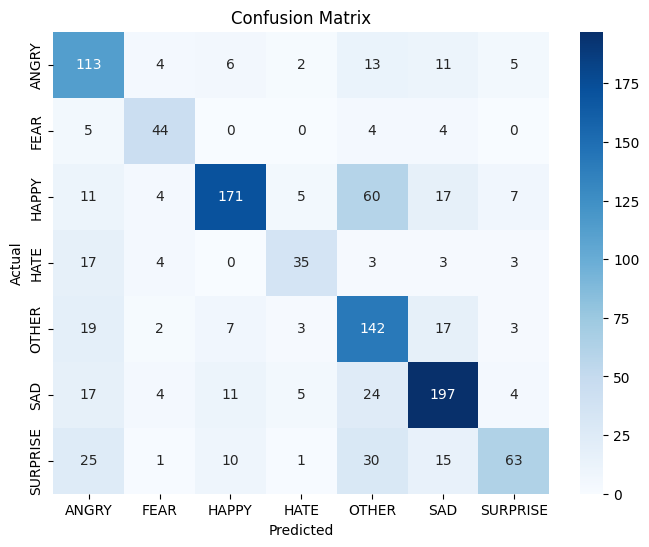

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)

# Decode labels (optional)
label_names = label_encoder.classes_

# Print detailed classification report
print(classification_report(test["label"], preds, target_names=label_names))

# Plot confusion matrix
cm = confusion_matrix(test["label"], preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [14]:
model.save_pretrained("./parsbert-emotion")
tokenizer.save_pretrained("./parsbert-emotion")

Configuration saved in ./parsbert-emotion/config.json
Model weights saved in ./parsbert-emotion/pytorch_model.bin
tokenizer config file saved in ./parsbert-emotion/tokenizer_config.json
Special tokens file saved in ./parsbert-emotion/special_tokens_map.json


('./parsbert-emotion/tokenizer_config.json',
 './parsbert-emotion/special_tokens_map.json',
 './parsbert-emotion/vocab.txt',
 './parsbert-emotion/added_tokens.json',
 './parsbert-emotion/tokenizer.json')

In [16]:
import shutil
shutil.make_archive("parsbert-emotion", 'zip', "./parsbert-emotion")

from IPython.display import FileLink
FileLink('parsbert-emotion.zip')

'/kaggle/working/parsbert-emotion.zip'

In [18]:
pip install streamlit

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 70.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.6 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
# app.py for using the API Interface
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load model & tokenizer
model = AutoModelForSequenceClassification.from_pretrained("parsbert-emotion")
tokenizer = AutoTokenizer.from_pretrained("parsbert-emotion")

labels = ['HAPPY', 'FEAR', 'SAD', 'HATE', 'ANGRY', 'SURPRISED', 'OTHER']

st.title("📘 Persian Emotion Classifier")

text = st.text_area("Enter Persian text:")

if st.button("Analyze Emotion"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).numpy()[0]

    st.write("### Prediction:")
    for i, prob in enumerate(probs):
        st.write(f"{labels[i]}: {prob:.2f}")

    st.bar_chart(probs)

loading configuration file parsbert-emotion/config.json
Model config BertConfig {
  "_name_or_path": "parsbert-emotion",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4